In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the csv file
userlog = pd.read_csv('user_logs.csv')
# Set datetime object as the index
userlog = userlog.set_index(userlog.datetime)
# Drop the original datetime column
userlog.drop(columns='datetime',inplace=True)

In [3]:
# Set 'datetime' as a datetime index.
userlog.index = pd.to_datetime(userlog.index)

In [4]:
# Verify index was set.
userlog.index

DatetimeIndex(['2018-01-26 09:55:03', '2018-01-26 09:56:02',
               '2018-01-26 09:56:05', '2018-01-26 09:56:06',
               '2018-01-26 09:56:24', '2018-01-26 09:56:41',
               '2018-01-26 09:56:46', '2018-01-26 09:56:48',
               '2018-01-26 09:56:59', '2018-01-26 09:58:26',
               ...
               '2021-04-21 16:38:14', '2021-04-21 16:41:29',
               '2021-04-21 16:41:31', '2021-04-21 16:41:49',
               '2021-04-21 16:41:51', '2021-04-21 16:41:51',
               '2021-04-21 16:42:02', '2021-04-21 16:42:09',
               '2021-04-21 16:44:37', '2021-04-21 16:44:39'],
              dtype='datetime64[ns]', name='datetime', length=847330, freq=None)

In [5]:
len(userlog.cohort_name.value_counts())

47

In [6]:
len(userlog.slack.value_counts())

46

In [7]:
userlog.cohort_name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: cohort_name, dtype: int64

In [8]:
userlog.slack.value_counts()

#              110569
#ceres          40730
#zion           38096
#jupiter        37109
#fortuna        36902
#voyageurs      35636
#ganymede       33844
#apex           33568
#deimos         32888
#darden         32015
#teddy          30926
#hyperion       29855
#betelgeuse     29356
#ulysses        28534
#europa         28033
#xanadu         27749
#wrangell       25586
#andromeda      25359
#kalypso        23691
#curie          21582
#yosemite       20743
#bash           17713
#luna           16623
#marco          16397
#easley         14715
#lassen          9587
#arches          8890
#florence        8562
#sequoia         7444
#neptune         7276
#olympic         4954
#kings           2845
#pinnacles       2158
#hampton         1712
#oberon          1672
#quincy          1237
#niagara          755
#mammoth          691
#glacier          598
#joshua           302
#ike              253
#badlands          93
#franklin          72
#apollo             5
#denali             4
#everglade

# Takeaways
* Bayes is missing a slack channel
* They may have been put in the '#' slack channel.

In [10]:
# Convert all datetime values into datetime datatype
userlog.end_date = pd.to_datetime(userlog.end_date)
userlog.start_date = pd.to_datetime(userlog.start_date)
userlog.created_at = pd.to_datetime(userlog.created_at)
userlog.updated_at = pd.to_datetime(userlog.updated_at)

In [11]:
# Drop 'deleted_at' column
userlog.drop(columns='deleted_at', inplace=True)

In [13]:
userlog.path.value_counts()

/                                            45854
javascript-i                                 18203
toc                                          17591
search/search_index.json                     17534
java-iii                                     13166
                                             ...  
ada-capsontes.html                               1
appendix/cli/moving-files                        1
java-i/control-stateedabitments-and-loops        1
javascript/apendix                               1
jacascript-i/introdection                        1
Name: path, Length: 2224, dtype: int64

# Takeaways
* 2224 different paths were accessed.

In [14]:
userlog.path.apply(type).value_counts()

<class 'str'>      847329
<class 'float'>         1
Name: path, dtype: int64

# Takeaways
* There is one observtion that is a float datatype that is screwing everything up.

In [15]:
# Drop nan values(there is only one)
userlog.dropna(inplace=True)

In [16]:
# Split the 'path' column at the backslash
userlog['path_split'] = userlog.path.str.split('/')

In [20]:
# Create a new column for module name and lesson
userlog['module'] = [mod[0] for mod in userlog.path_split]
# Create a second item for the lists that only have one time
for mod in userlog.path_split:    
    if len(mod) == 1:
        mod = mod.append('')

userlog['lesson'] = [mod[1] for mod in userlog.path_split]

# Takeaways
* The dataframe is wrangled and now ready for exploration.

In [40]:
userlog.index.min(), userlog.index.max()

(Timestamp('2018-01-26 09:55:03'), Timestamp('2021-04-21 16:44:39'))

In [26]:
userlog.program_id.value_counts()

2    713365
3    103411
1     30548
4         5
Name: program_id, dtype: int64

In [38]:
userlog[userlog.program_id == 4].lesson.value_counts().head(50)

html-css    4
            1
Name: lesson, dtype: int64

In [41]:
userlog['program'] = userlog.program_id.map(
    {
        1.0: 'Full-Stack PHP',
        2.0: 'Full-Stack Java',
        3.0: 'Data Science',
        4.0: 'Front-End'
    })

In [48]:
userlog[userlog.program_id == 2]

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program
datetime,,,,,,,,,,,,,,,
2018-01-26 09:56:24,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,2,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java
2018-01-26 09:56:41,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/loops,2,97.105.19.61,"[javascript-i, loops]",javascript-i,loops,Full-Stack Java
2018-01-26 09:56:46,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,3,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java
2018-01-26 09:56:48,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/functions,3,97.105.19.61,"[javascript-i, functions]",javascript-i,functions,Full-Stack Java
2018-01-26 09:56:59,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/loops,2,97.105.19.61,"[javascript-i, loops]",javascript-i,loops,Full-Stack Java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/personal-site,64,71.150.217.33,"[jquery, personal-site]",jquery,personal-site,Full-Stack Java
2021-04-21 16:42:02,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/mapbox-api,64,71.150.217.33,"[jquery, mapbox-api]",jquery,mapbox-api,Full-Stack Java
2021-04-21 16:42:09,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/ajax/weather-map,64,71.150.217.33,"[jquery, ajax, weather-map]",jquery,ajax,Full-Stack Java


### At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [45]:
userlog.program.value_counts()

Full-Stack Java    713365
Data Science       103411
Full-Stack PHP      30548
Front-End               5
Name: program, dtype: int64

In [49]:
userlog['ds_student'] = userlog.program_id == 3

### Check to see which webpages the Data Science students are visiting

In [87]:
userlog[userlog.ds_student == True].module.value_counts()[:50]

fundamentals                        8746
classification                      8620
                                    8358
1-fundamentals                      7945
sql                                 7505
3-sql                               6165
python                              5599
4-python                            4856
6-regression                        4562
appendix                            3944
5-stats                             3361
stats                               3299
7-classification                    3220
regression                          2945
search                              2206
clustering                          2191
10-anomaly-detection                2185
anomaly-detection                   2147
8-clustering                        2081
11-nlp                              1865
9-timeseries                        1723
storytelling                        1685
2-storytelling                      1627
timeseries                          1592
nlp             

In [88]:
userlog[userlog.ds_student == True].module.value_counts()[50:100]

overview                                          8
spring                                            8
java-i                                            8
curie-python-assessment                           7
regular-expressions                               6
darden-python-assessment.html                     6
Hospital-Distance-Clusters.jpg                    5
java-ii                                           5
mysql-introduction                                5
1.2-data-science-pipeline                         5
prepare                                           5
model                                             5
Pipeline_Demo                                     4
bayes-python-assessment-4586.html                 4
functions                                         4
1.3-pipeline-demo                                 4
jquery                                            4
scale_features_or_not.svg                         4
find_me_curie!(12.3.19)                           4
javascript-i

# Takeaways
* The Data Science students during the time this data was captured did not visit many Web Development pages.

In [71]:
# Check the number of users in this dataset.
userlog.ip.unique().shape[0]

5200

### Check to see which webpages the Web Development students are visiting.

In [84]:
userlog[userlog.ds_student == False].module.value_counts()[:50]

javascript-i                  113826
html-css                       81464
mysql                          79407
jquery                         58313
spring                         55473
java-iii                       54560
java-ii                        52920
java-i                         39636
                               37496
javascript-ii                  37473
appendix                       31655
toc                            17580
search                         15333
examples                       14167
content                         9102
slides                          7319
capstone                        2849
classification                  2833
fundamentals                    2381
web-design                      2103
1-fundamentals                  2025
mkdocs                          1865
index.html                      1722
sql                             1530
10-anomaly-detection            1331
6-regression                    1283
3-sql                           1243
p

In [85]:
userlog[userlog.ds_student == False].module.value_counts()[50:100]

assets                              158
13-advanced-topics                  124
distributed-ml                      117
git                                 109
2-stats                             108
Regression_Python                    88
introduction                         69
4.6.3_introduction_to_pandas         69
Pipeline_Demo                        67
elements                             57
2.01.00_Descriptive_Stats            56
7-clustering                         53
Intro_to_Regression                  51
ordinary_least_squares.jpeg          50
4.2_data_types_and_variables         50
4.3_control_structures               46
Regression_Project                   43
login                                43
4.4_functions                        43
4.0_overview                         42
css-ii                               42
2.00.02_Navigating_Excel             41
css-i                                41
2.00.00_Excel_Prob_Stats             40
6_Exercises                          40


In [86]:
userlog[userlog.ds_student == False].module.value_counts()[100:150]

study-session-with-ryan                  28
2.02.05_Compare_Means                    28
forms                                    28
10.01_Acquire_WebScraping                28
10.4_Prepare                             27
2.02.00_Inferential_Stats                27
Exercises                                27
8_Exercises                              26
professional-development                 26
12.1_Tidy_Data                           26
javascript                               25
3.10-more-exercises                      25
users                                    25
2.00.05_Charts_PivotTables_Sparklines    25
8.1_Overview                             24
3.2-databases                            24
2.02.02_Sampling                         24
6_Project                                24
7.5.1_KMeans1                            23
10_Exercises                             23
12.01_SocialNetworkAnalysis              23
10._NLP                                  23
13.1_Understand                 

# Takeaways
* The Web Development students visited Data Science webpages a lot more than Data Science students visited Web Development pages.

### Resample the data by day and plot number of page visits/day for Web Development students.

In [102]:
web_dev_page_visits = userlog[userlog.ds_student == False].resample('d').path.count()

<AxesSubplot:xlabel='datetime'>

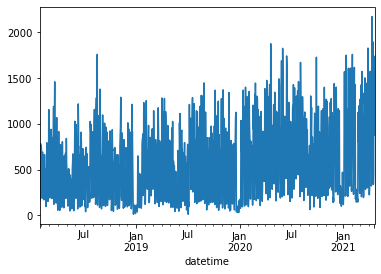

In [103]:
web_dev_page_visits.plot()

## Use Bolinger Bands to set upper and lower limits for normal activity. This method will be used to identify abnormal page visits.

### Set Midband

#### The Exponential Moving Average

In [104]:
# Compute the midband.
midband = web_dev_page_visits.ewm(span=30).mean()

<AxesSubplot:xlabel='datetime'>

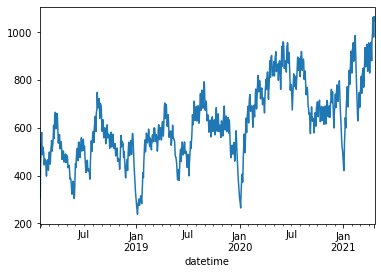

In [105]:
midband.plot()

## Set Upper & Lower Band

UB/LB = Midband +/- stdev * K

In [106]:
# Compute the exponential standard deviation.
stdev = web_dev_page_visits.ewm(span=30).std()

In [108]:
# Compute the upper and lower bands.
ub = midband + stdev*2
lb = midband - stdev*2
ub, lb

(datetime
 2018-01-26            NaN
 2018-01-27     804.956709
 2018-01-28     687.762221
 2018-01-29    1019.718202
 2018-01-30    1001.085795
                  ...     
 2021-04-17    2201.651173
 2021-04-18    2160.325686
 2021-04-19    2232.663074
 2021-04-20    2263.411015
 2021-04-21    2215.736176
 Freq: D, Name: path, Length: 1182, dtype: float64,
 datetime
 2018-01-26           NaN
 2018-01-27    -52.056709
 2018-01-28    -83.192803
 2018-01-29   -150.239623
 2018-01-30    -50.034912
                  ...    
 2021-04-17   -169.996110
 2021-04-18   -201.035466
 2021-04-19   -175.004481
 2021-04-20   -132.827169
 2021-04-21   -109.706127
 Freq: D, Name: path, Length: 1182, dtype: float64)

In [110]:
# Concatenate upper band and lower band together into one dataframe, bb.
bb = pd.concat([ub, lb], axis=1)
# Set names of columns.
bb.columns = ['ub', 'lb']

# Create a dataframe that holds the values for 'pages', 'midband', and the newly created 'bb'.
my_df = pd.concat([web_dev_page_visits, midband, bb], axis=1)
my_df.columns = ['web_dev_page_visits', 'midband', 'ub', 'lb']
my_df.head()

,web_dev_page_visits,midband,ub,lb
datetime,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


## Plot number of page visits along with the Bollinger Bands

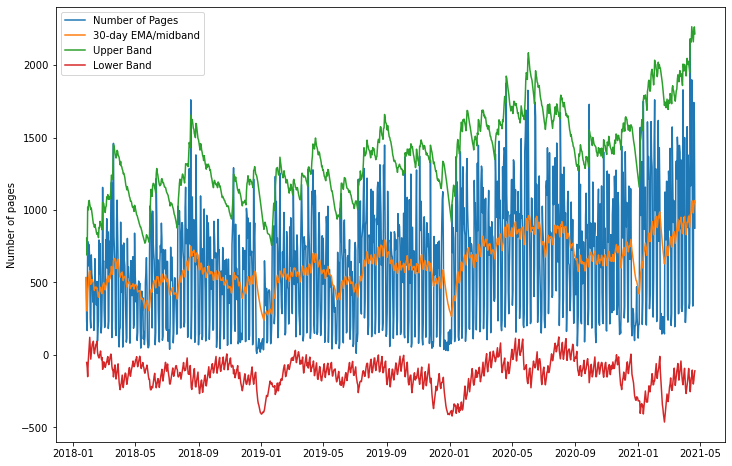

In [111]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.web_dev_page_visits, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()